# Configure directories

> * Mount Drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


> * Configure kaggle directory

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"
# /content/gdrive/MyDrive/kaggle is the path where kaggle.json is present in the Google Drive

> * Change to the project directory

In [3]:
#changing the working directory
%cd /content/gdrive/MyDrive/kaggle/cats-vs-dogs/
#Check the present working directory using pwd command

/content/gdrive/MyDrive/kaggle/cats-vs-dogs


# Download data

> * Download and unzip data

In [ ]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
# train data
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# test data
local_zip = 'test1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

# Resize images

In [ ]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array

> * Resize images in the **train** directory

In [ ]:
# define location of dataset
source_dir = '/content/gdrive/My Drive/kaggle/cats-vs-dogs/train/'
# enumerate files in the directory
for file in listdir(source_dir):
  # load image, resize and save it
  photo = load_img(source_dir + file, target_size=(200, 200))
  save_img(source_dir + file, photo)

> * Resize images in the **test** directory

In [ ]:
# define location of dataset
source_test_dir = '/content/gdrive/My Drive/kaggle/cats-vs-dogs/test1/'
# enumerate files in the directory
for file in listdir(source_test_dir):
	# load image, resize and save it
  photo = load_img(source_test_dir + file, target_size=(200, 200))
  save_img(source_test_dir + file, photo)

# Plot the first few images

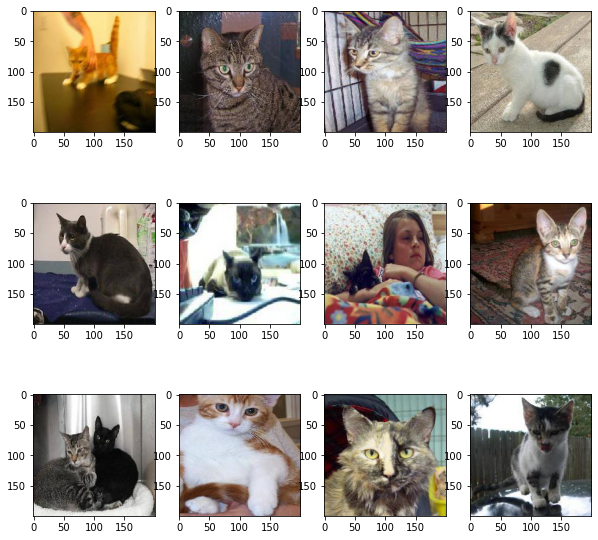

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
plt.figure(figsize=(10,10))
for i in range(12):
	# define subplot
	plt.subplot(3,4,i+1)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

# Initialize directories for training and validating and subdirectories for two image classes

The directory structure we aim at is as following.

Base directory is the project directory. The subdirectories in the base directory are:

* train (*source directory* containing raw *dogs_vs_cats* data) 
* validaing (*destination directory* for validating data)
  * cats
  * dogs
* training (*destination directory* for training data)
  * cats
  * dogs

In [ ]:
try:
  #set the base directory to be the project directory
    base_dir = '/content/gdrive/My Drive/kaggle/cats-vs-dogs'
    #initialize directories for testing and training and subdirectories for cats and dogs
    for directory in ('training', 'validating'):
        for sub_directory in ('cats','dogs'):
            path = os.path.join(base_dir, directory, sub_directory)
            os.makedirs(path,exist_ok=True)
except OSError:
    pass

# Split the data into validating and training data sets 

In [ ]:
from random import seed
from random import random
from shutil import copyfile
import sys

# set the directories according to the structure defined before
base_dir = '/content/gdrive/My Drive/kaggle/cats-vs-dogs/'
source_dir = '/content/gdrive/My Drive/kaggle/cats-vs-dogs/train/'
# set the splitting ratio
split_ratio = 0.25

#seed=1 to make sure we get the same split each time the code is run
seed(1)
counter = 0
#
for file in listdir(source_dir):
  src = source_dir + '/' + file
  dst_dir = 'training/'
  if random() < split_ratio:
    dst_dir = 'validating/'
  #
  # select cats' images
  if file.startswith('cat'):
    dst = base_dir + dst_dir + 'cats/'  + file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = base_dir + dst_dir + 'dogs/'  + file
    copyfile(src, dst)
  #
  # print progress every 10th iteration
  counter +=1 
  if counter%100==0:
    ii=(counter/len(listdir(source_dir))*100)
    print("\r Progress: {} %".format(ii), end="")


 Progress: 100.0 %

# Construct a model

> * Contruct a simple model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',  kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',  kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',  kernel_initializer='he_uniform', padding='same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0

# Setup data generators for training and validation

> * Use data augmentation for training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/gdrive/My Drive/kaggle/cats-vs-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=22.5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=10,
                                                   class_mode='binary',
                                                   target_size=(200,200))

VALIDATION_DIR = "/content/gdrive/My Drive/kaggle/cats-vs-dogs/validating/"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size=10,
                                                             class_mode = 'binary',
                                                             target_size=(200,200))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


# Train the model

> * Train only for 1 epoch to test the model
> * Save the model

In [ ]:
history = model.fit(train_generator,
                              epochs=1,
                              verbose=1,
                              validation_data=validation_generator)
model.save('cats-vs-dogs-model.h5')

1870/1870 [==============================] - 4554s 2s/step - loss: 0.6448 - acc: 0.6172 - val_loss: 0.5714 - val_acc: 0.6962


# Setup data generator for testing

> * Set the test directory ```TEST_DIR```
> * Create a ```test_filenames``` dataframe containing filepaths relative to the test_directory.
> * Initialze the test data generator.
> * In the test data generator:
> * Set the dataframe to ```test_df```
> * Set the directory to ```TEST_DIR```
> * Set the class mode to ```None``` (there is no need to return any targets as the generator will only yield batches of image data needed by ```model.predict()```)
> * Set the ```target_size``` to (200,200) (I suppose this number must match the size of the images which was set earlier upon resizing)
> * Set the ```batch_size``` to 1.
> * ```shuffle=False``` sort the images in alphanumeric order.


In [66]:
import pandas as pd

TEST_DIR = "/content/gdrive/My Drive/kaggle/cats-vs-dogs/test1/"

test_filenames = [file for file in os.listdir(TEST_DIR) if file.endswith('.jpg')]
test_df = pd.DataFrame({'filename': test_filenames})

from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  TEST_DIR, 
                                                  class_mode=None,
                                                  target_size=(200,200),
                                                  batch_size=1,
                                                  shuffle=False)

Found 12500 validated image filenames.


# Make predictions
> * Set the input samples to  ```test_generator``` 
> * Set ```verbose = 1``` to plot the progress
> * Set the number of steps to the number of test images.

In [7]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/kaggle/cats-vs-dogs/cats-vs-dogs-model.h5')

In [10]:
predictions = model.predict(test_generator, verbose=1, steps = len(test_filenames))

12500/12500 [==============================] - 4152s 332ms/step


> * ```predictions``` is a list of probabilities. 

In [53]:
predictions

array([[0.94664365],
       [0.5117013 ],
       [0.20351985],
       ...,
       [0.9363798 ],
       [0.1849276 ],
       [0.51346517]], dtype=float32)

> * Convert predicted probabilites into categorical labels
(for probability > 0.5, set the predicted_label to 1 (dog), and set it to 0 (cat) elsewhere)

In [56]:
predicted_label = []
predicted_label = [int(round(probability[0])) for probability in predictions]


> * Generate images' IDs from the test dataframe

In [57]:
import numpy as np
id = test_df['filename'].str.split('.').str[0]
id = [np.int(ids) for ids in id]

> * Create a dataframe for submission
> * Set the IDs and the labels and sort by the ID number.

In [58]:
submission_df = pd.DataFrame({'id':id, 'label':predicted_label})
submission_df = submission_df.sort_values(by=['id'])

> * Save the submission to a csv file.

In [59]:
submission_df.to_csv("submission.csv", index=False)

In [81]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
sample_test = submission_df.head(15)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['id']
    label = row['label']
    if label == 0:
      label_final = "cat"
    else:
      label_final = "dog"
    img = load_img(TEST_DIR+str(filename)+'.jpg', target_size=(200,200))
    plt.subplot(5, 3, filename)
    plt.imshow(img)
    plt.xlabel("image " + str(filename) + ' (' + "{}".format(label_final) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.